## Preprocessing


### Read files - assign labels - encode labels

In [9]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data_folder = 'data'

def read_file(file_path):
    with open(file_path, 'r') as file:
         data_str = file.read()
    data_str_filtered = data_str.translate(str.maketrans('', '', '[],'))
    data_list = [float(item) for item in data_str_filtered.split() if item]
    data_array = np.array(data_list)
    reshaped_data = data_array.reshape(140, 61, 1)
    return reshaped_data

def assign_label(file_name):
    if 'bottle' in file_name: return 'Bottle'
    elif 'cap' in file_name: return 'Cap'
    elif 'wall' in file_name: return 'Wall'
    elif 'shoe' in file_name: return 'Shoe'    
    else: return 'Unknown'

data_labels = []
all_data = []  # Collect all data for finding the global maximum

for file_name in os.listdir(data_folder):
    file_path = os.path.join(data_folder, file_name)
    if os.path.isfile(file_path):
        content = read_file(file_path)
        all_data.append(content)  # Add content to all_data list
        label = assign_label(file_name)
        data_labels.append((content, label))

# Convert all_data to a single numpy array to find the global maximum
all_data_np = np.concatenate(all_data, axis=0)
global_max = np.max(all_data_np)

# Normalize each data entry based on the global maximum
normalized_data_labels = [(content/global_max, label) for content, label in data_labels]

X, y = zip(*normalized_data_labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print('Training data size:', len(X_train))
print('Test data size:', len(X_test))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data'

## Vizualization

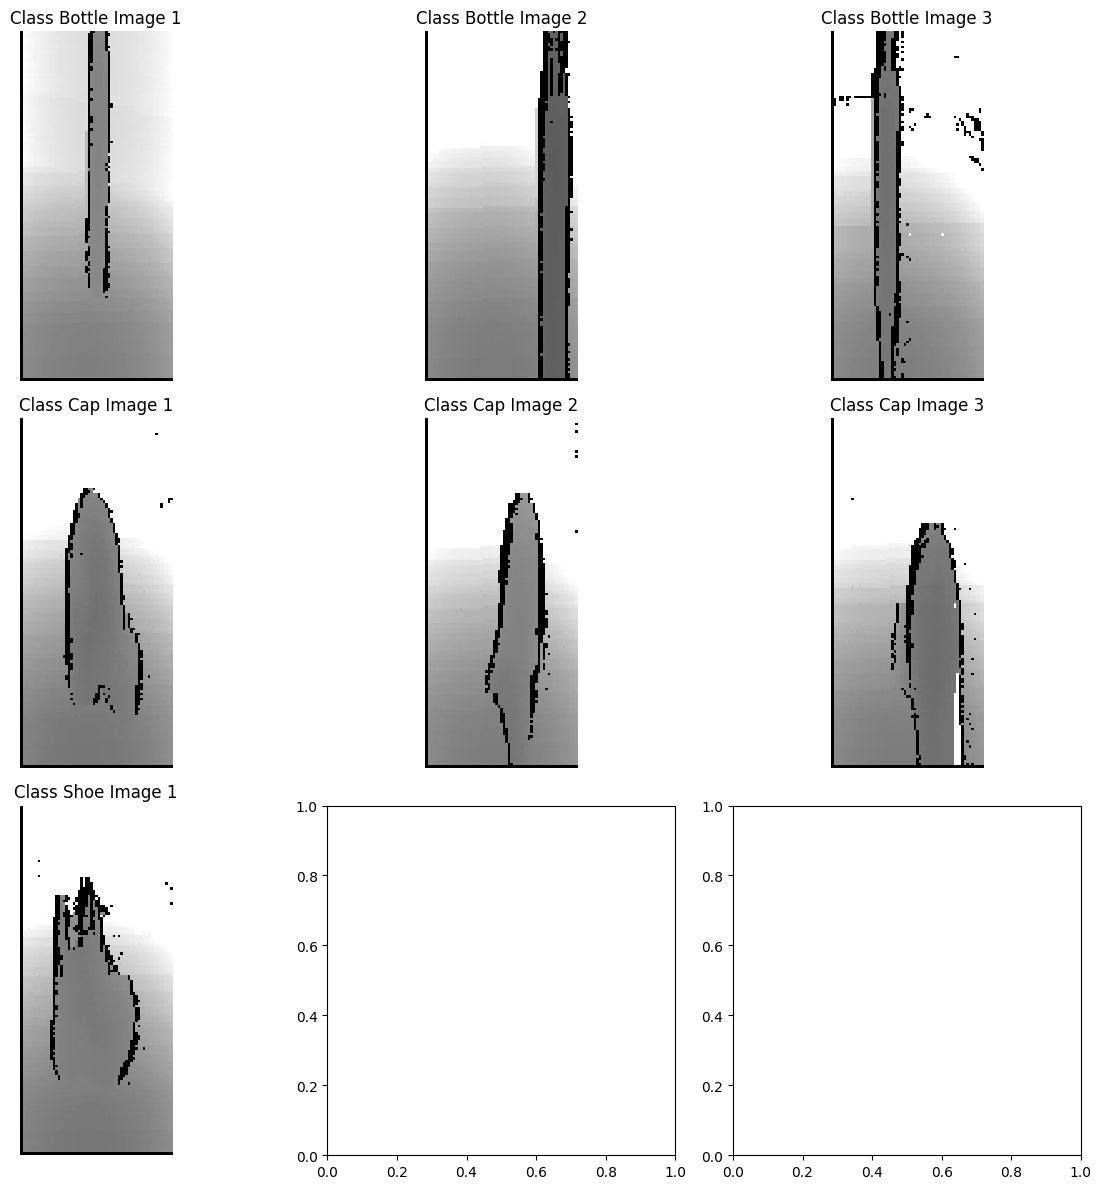

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' is your images array and 'y_encoded' are your numerically encoded labels
unique_classes = np.unique(y_encoded)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Set up a 3x3 grid
axes = axes.flatten()  # Flatten the axes array for easier use

for i, cls in enumerate(unique_classes):
    cls_indices = np.where(y_encoded == cls)[0][:3]  # Get first 3 indices of each class
    for j, idx in enumerate(cls_indices):
        if i*3+j >= 9:  # Stop after filling the 3x3 grid
            break
        image = X[idx]  # Replace this with actual image fetching logic
        # Preprocess the image as needed
        clipped_array = np.clip(image, None, 1000)
        flipped_array = np.flipud(clipped_array)

        axes[i*3+j].imshow(flipped_array, cmap='gray', interpolation='nearest')
        axes[i*3+j].set_title(f'Class {label_encoder.inverse_transform([cls])[0]} Image {j+1}')
        axes[i*3+j].axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()